In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet201
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import datetime

In [3]:
print(tf.config.list_physical_devices('GPU'))
print("GPU:", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow Version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU: 1
Tensorflow Version 2.6.0


In [5]:
batch_size = 64
img_height = 224
img_width = 224
epochs = int(input("Enter epochs number: "))

Enter epochs number:  30


In [7]:
data_dir = r"D:\Project\aug_data\paper_data_aug"

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2519 files belonging to 5 classes.
Using 2016 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2519 files belonging to 5 classes.
Using 503 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['Amanita citrina', 'Amanita muscaria', 'Amanita pantherina', 'Amanita rubescens', 'Apioperdon pyriforme']


In [15]:
print("Training class names:", train_ds.class_names)
print("Validation class names:", val_ds.class_names)

Training class names: ['Amanita citrina', 'Amanita muscaria', 'Amanita pantherina', 'Amanita rubescens', 'Apioperdon pyriforme']
Validation class names: ['Amanita citrina', 'Amanita muscaria', 'Amanita pantherina', 'Amanita rubescens', 'Apioperdon pyriforme']


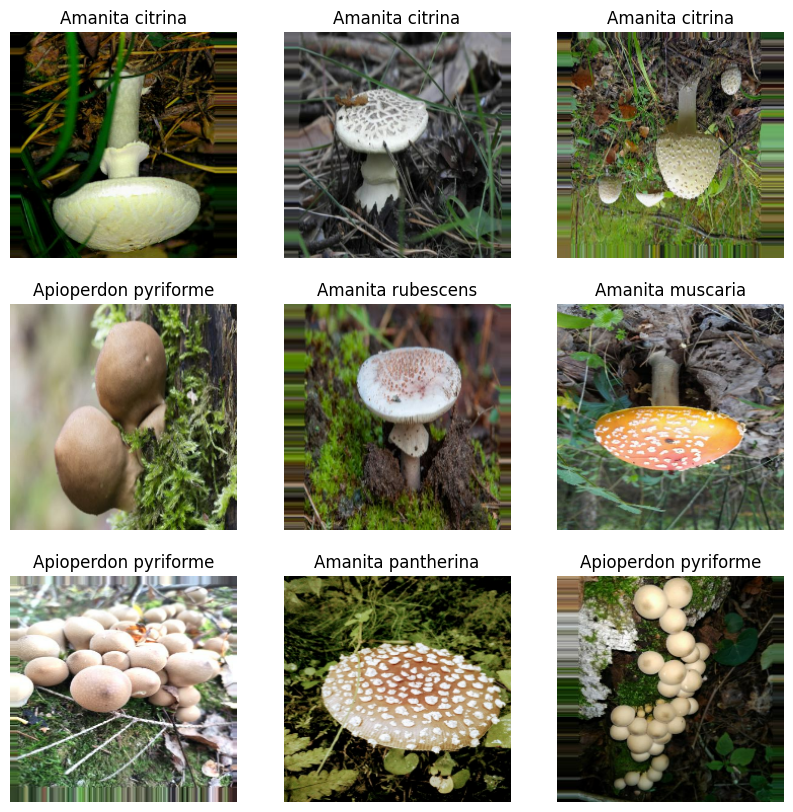

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs, x)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 19,308,101
Trainable params: 986,117
Non-trainable params: 18,321,984
___________________________________________

In [23]:
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
  metrics=['accuracy']
)

In [25]:
history = model.fit(
  train_ds, 
  epochs=epochs, 
  validation_data=val_ds
)

Epoch 1/30
32/32 [==============================] - 81s 1s/step - loss: 7.8504 - accuracy: 0.4598 - val_loss: 3.8432 - val_accuracy: 0.7396
Epoch 2/30
32/32 [==============================] - 17s 501ms/step - loss: 3.3331 - accuracy: 0.7004 - val_loss: 2.7060 - val_accuracy: 0.8231
Epoch 3/30
32/32 [==============================] - 16s 490ms/step - loss: 2.5420 - accuracy: 0.7961 - val_loss: 2.1936 - val_accuracy: 0.8509
Epoch 4/30
32/32 [==============================] - 16s 490ms/step - loss: 2.1161 - accuracy: 0.8309 - val_loss: 1.8998 - val_accuracy: 0.8429
Epoch 5/30
32/32 [==============================] - 16s 490ms/step - loss: 1.7707 - accuracy: 0.8760 - val_loss: 1.5703 - val_accuracy: 0.9105
Epoch 6/30
32/32 [==============================] - 16s 487ms/step - loss: 1.5249 - accuracy: 0.8943 - val_loss: 1.4111 - val_accuracy: 0.9105
Epoch 7/30
32/32 [==============================] - 17s 504ms/step - loss: 1.3312 - accuracy: 0.9058 - val_loss: 1.2017 - val_accuracy: 0.9324
Ep

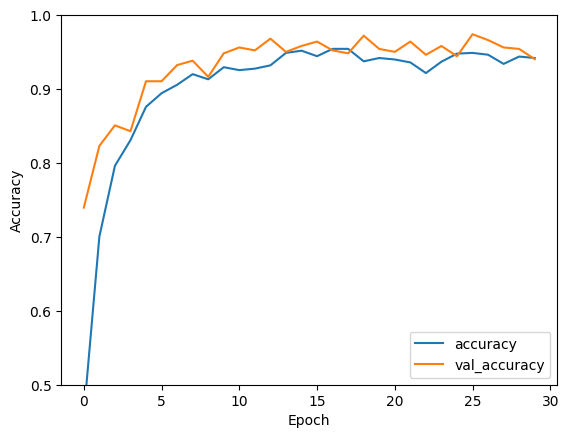

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

8/8 - 3s - loss: 0.4728 - accuracy: 0.9404


In [28]:
print(test_acc)

0.9403578639030457


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_true_labels(dataset):
    '''Extracts true labels from a TensorFlow dataset'''
    true_labels = []
    for _, labels in dataset: 
        true_labels.extend(labels.numpy()) 
    return np.array(true_labels)

def conf_matrix(model, dataset, class_types):
    '''Plots confusion matrix and classification report'''
    
    true_labels = get_true_labels(dataset)

    predictions = model.predict(dataset)
    predicted_classes = np.argmax(predictions, axis=1)  # Convert softmax to class indices

    cm = confusion_matrix(true_labels, predicted_classes)

    print("Classification Report:\n")
    print(classification_report(true_labels, predicted_classes, target_names=class_types))

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_types, yticklabels=class_types)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Classification Report:

                      precision    recall  f1-score   support

     Amanita citrina       0.22      0.20      0.21       102
    Amanita muscaria       0.19      0.19      0.19        97
  Amanita pantherina       0.25      0.24      0.24        88
   Amanita rubescens       0.23      0.28      0.25       101
Apioperdon pyriforme       0.21      0.19      0.20       115

            accuracy                           0.22       503
           macro avg       0.22      0.22      0.22       503
        weighted avg       0.22      0.22      0.22       503



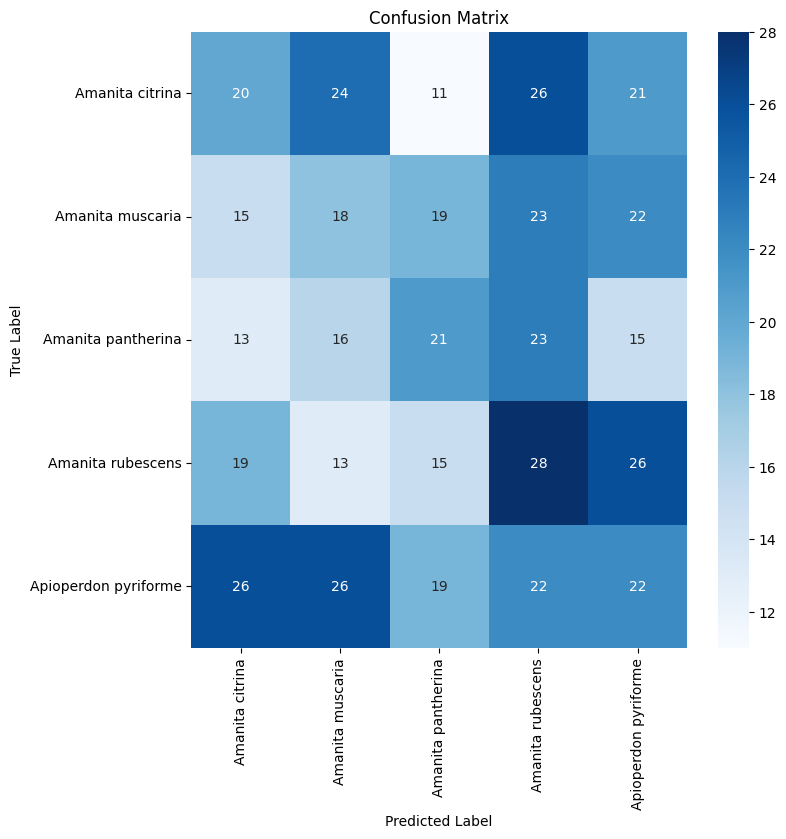

In [30]:
conf_matrix(model, val_ds, class_names)

In [31]:
model_version = epochs
next_version = str(int(model_version) + 10) 
model_filename = f"DenseNet_{model_version}_ADAM_model.h5"
model.save(model_filename)
print(f"Model saved as {model_filename}")

Model saved as DenseNet_30_ADAM_model.h5


In [32]:
import shutil

notebook_filename = f"DenseNet_{model_version}_ADAM.ipynb"
new_notebook_filename = f"DenseNet_{next_version}_ADAM.ipynb"

shutil.copy(notebook_filename, new_notebook_filename)
print(f"Notebook copied as {new_notebook_filename}")

Notebook copied as DenseNet_40_ADAM.ipynb


In [ ]:
os._exit(00)